In [ ]:
pip install --upgrade transformers sympy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 78.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 94.3 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.1
    Uninstalling sympy-1.13.1:
      Successfully uninstalled sympy-1.13.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.47.1
    Uninstalling transformers-4.47.1:
      Successfully uninstalled transformers-4.47.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system ==

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu


Processing Fold 1...


100%|██████████| 27/27 [11:50<00:00, 26.30s/it]


Fold 1 Accuracy: 0.70
Processing Fold 2...


100%|██████████| 27/27 [10:23<00:00, 23.09s/it]


Fold 2 Accuracy: 0.67
Processing Fold 3...


100%|██████████| 27/27 [10:15<00:00, 22.81s/it]


Fold 3 Accuracy: 0.67
Processing Fold 4...


100%|██████████| 27/27 [11:16<00:00, 25.04s/it]


Fold 4 Accuracy: 0.59
Processing Fold 5...


100%|██████████| 27/27 [09:26<00:00, 20.99s/it]


Fold 5 Accuracy: 0.67

Overall Mean Accuracy: 0.66
Overall Standard Deviation of Accuracy: 0.04


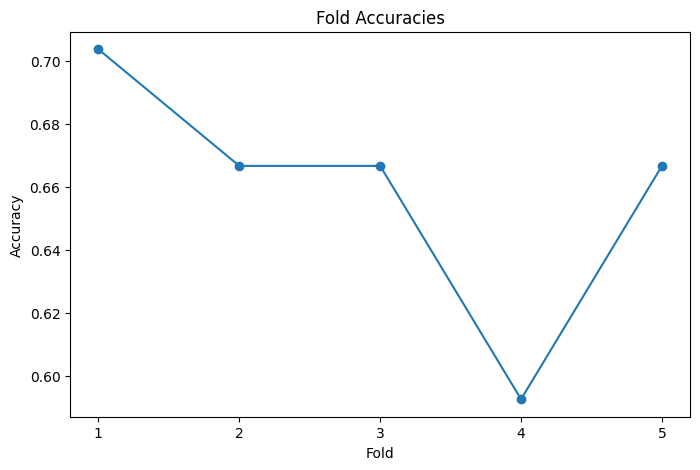


Average Accuracy Across Folds: 0.66


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import KFold, train_test_split
from tqdm import tqdm

# Load the AG News dataset
def load_ag_news():
    train_data = pd.read_csv("train.csv", encoding="ISO-8859-1")  # Adjust encoding if necessary
    data = train_data.copy()
    data.columns = ['Class', 'Title', 'Content']
    data['Text'] = data['Title'] + " " + data['Content']
    return data

# Load and prepare the data
data = load_ag_news()
class_mapping = {
    0: "Financial updates: Company-specific quarterly, annual, or monthly financial performance reports or statements",
    1: "Financial: Capital raising activities such as public offerings, loan or lease arrangements, and private placements",
    2: "Financial: Dividend Declared",
    3: "Financial: Annual and quater meetings",
    4: "Technical: Discovery of Gold",
    6: "Operational: Expansion of mining operations (including M&A)",
    7: "Operational: Opening or closure of mining",
    8: "Operational updates: Changes in production output or efficiency",
    9: "Operational: Changes in key management positions",
    10: "Regulatory: Updates on lawsuits or penalties, compliance with regulatory standards, sustainability and corporate governance",
    11: "Regulatory: Approval or rejection of mining permits & licenses",
    24: "Geopolitical events: Political instability or conflicts",
                 }

data['Class'] = data['Class'].map(class_mapping)

# Take a random sample to reduce processing time
sample_size = 169  # Adjust this number according to your processing capacity
data_sample = data.sample(n=sample_size, random_state=42)

# Split the data into train and test sets
train_data, test_data = train_test_split(data_sample, test_size=0.2, random_state=42)

# Prepare the Zero-Shot classifier
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=0)

# Function to evaluate the classifier

def evaluate_zero_shot_classifier(texts, labels, all_labels):
    predicted_labels = []
    true_labels = []
    confidences = []

    for text, true_label in tqdm(zip(texts, labels), total=len(texts)):
        result = classifier(text, all_labels)
        predicted_label = result['labels'][0]

        true_labels.append(true_label)
        predicted_labels.append(predicted_label)
        confidences.append(result['scores'][0])

    return true_labels, predicted_labels, confidences

# Perform K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Ensure 'Class' column is of string type and get unique labels
train_data['Class'] = train_data['Class'].astype(str)
all_labels = sorted(train_data['Class'].unique())

fold_accuracies = []

# Loop through each fold
for fold, (train_index, test_index) in enumerate(kf.split(train_data)):
    print(f"Processing Fold {fold + 1}...")

    # Split data into train and test for this fold
    train_fold = train_data.iloc[train_index]
    test_fold = train_data.iloc[test_index]

    true_labels = []
    predicted_labels = []
    confidences = []

    # Evaluate on the test fold
    for _, row in tqdm(test_fold.iterrows(), total=len(test_fold)):
        result = classifier(row['Text'], all_labels)
        predicted_label = result['labels'][0]

        true_labels.append(row['Class'])
        predicted_labels.append(predicted_label)
        confidences.append(result['scores'][0])

    # Calculate accuracy for this fold
    accuracy = accuracy_score(true_labels, predicted_labels)
    fold_accuracies.append(accuracy)
    print(f"Fold {fold + 1} Accuracy: {accuracy:.2f}")

# Print overall results
mean_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)
print(f"\nOverall Mean Accuracy: {mean_accuracy:.2f}")
print(f"Overall Standard Deviation of Accuracy: {std_accuracy:.2f}")


# Visualize fold accuracies
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(fold_accuracies) + 1), fold_accuracies, marker='o')
plt.title('Fold Accuracies')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.xticks(range(1, len(fold_accuracies) + 1))
plt.show()

print(f"\nAverage Accuracy Across Folds: {np.mean(fold_accuracies):.2f}")
